In [1]:
from src.psk_modem import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

### Task 1

In [2]:
# settings
np.random.seed(0)
fs_hz = 1000
fc_hz =  50
symb_per_sec_no_mult = 20
symb_per_sec = 10
modulation = "qpsk" # [bpsk, qpsk, 8psk]
num_transmit_bits = 96

# modem block init
modem_block = PSKModem(modulation)

# FFT settings
n_fft = 4 * (num_transmit_bits // modem_block.get_bits_per_symbol * int(fs_hz / symb_per_sec))
freqs = np.linspace(-fs_hz/2, fs_hz/2, n_fft)

In [3]:
# processing block
bit_message = np.random.randint(low=0, high=2, size=num_transmit_bits)
symbols = modem_block.map_symbols(bit_message)
signal1 = modem_block.modulate(bit_message, fs_hz, fc_hz, symb_per_sec)
signal2 = modem_block.modulate(bit_message, fs_hz, fc_hz, symb_per_sec_no_mult)
time_array1 = np.arange(0, len(signal1), 1) / fs_hz
time_array2 = np.arange(0, len(signal2), 1) / fs_hz
rec_bits1, metrics1 = modem_block.demodulate(signal1, fs_hz, fc_hz, symb_per_sec)
rec_bits2, metrics2 = modem_block.demodulate(signal2, fs_hz, fc_hz, symb_per_sec_no_mult)
print('Bit message: ', *bit_message)
print('Modulation symbols: ', *np.round(symbols, 2))
print('Demodulated bits1: ', *rec_bits1, "Correct: ", np.array_equal(rec_bits1, bit_message))
print('Demodulated metrics1: ', metrics1, 2)
print('Demodulated bits2: ', *rec_bits2, "Correct: ", np.array_equal(rec_bits2, bit_message))
print('Demodulated metrics2: ', metrics2)

Bit message:  0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0
Modulation symbols:  1j (-0-1j) (-1+0j) (-1+0j) (-1+0j) (-0-1j) 1j (1+0j) (1+0j) 1j 1j (-0-1j) 1j (-1+0j) (-0-1j) (-0-1j) (-0-1j) (-1+0j) 1j (-0-1j) 1j 1j (-1+0j) (-1+0j) 1j 1j (-1+0j) (-0-1j) (-0-1j) 1j (-0-1j) (-0-1j) (-0-1j) (1+0j) (1+0j) (-1+0j) (1+0j) 1j (-0-1j) (-0-1j) 1j 1j (-1+0j) (-1+0j) (-0-1j) (-1+0j) (1+0j) (-0-1j)
Demodulated bits1:  0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 Correct:  True
Demodulated metrics1:  {(0, 1): np.float64(-0.5000000000000001), (0, 0): np.float64(-3.7192471324942746e-17), (1, 0): np.float64(0.5000000000000001), (1, 1): np.float64(-6.494804694057165e-17)} 2
Demodulated bits2:  0 1 1 0 1 1 1 1 1 1 1 

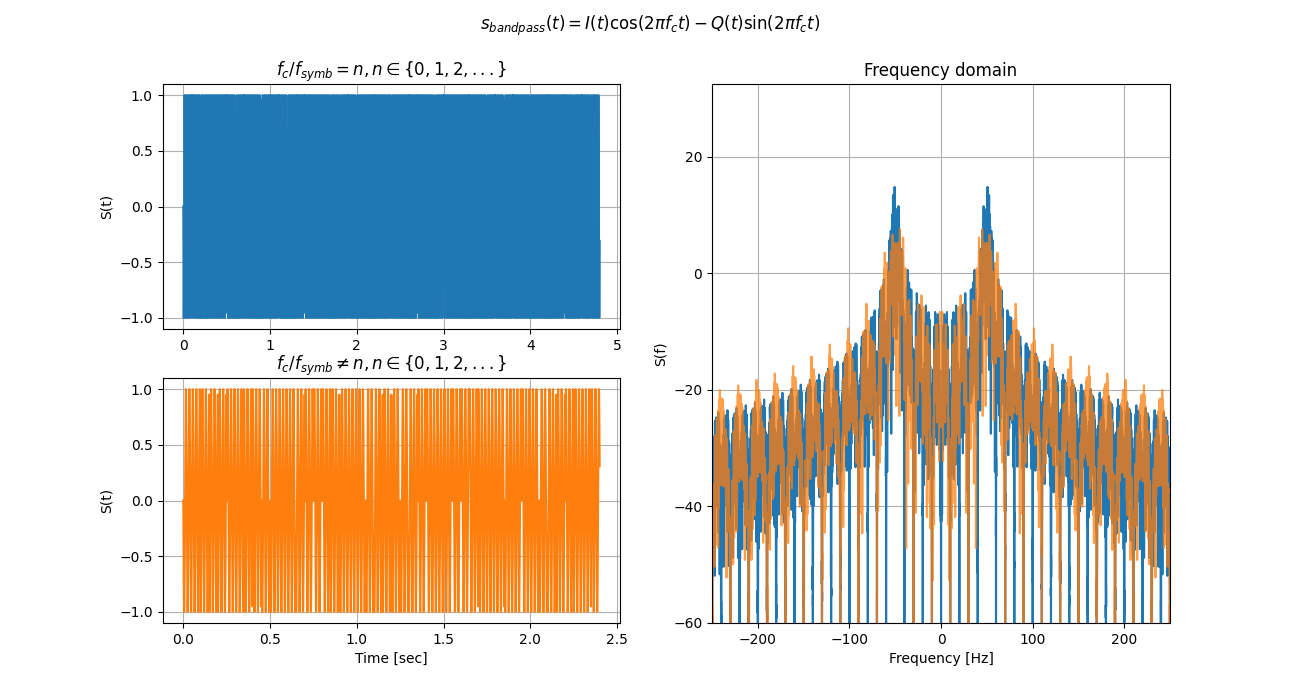

In [4]:
fig1_1 = plt.figure(figsize=(13,7))
fig1_1.suptitle(r'$s_{bandpass}(t)=I(t)\cos(2\pi f_c t)-Q(t)\sin(2\pi f_c t)$')
ax1 = fig1_1.add_subplot(221)

ax1.set_title(r"$f_c/f_{symb}=n, n \in \{0, 1, 2, ...\}$")
ax1.plot(time_array1, signal1, color="C0")
ax1.set_ylabel('S(t)')
ax1.grid()

ax2 = fig1_1.add_subplot(223)

ax2.set_title(r"$f_c/f_{symb}\neq n, n \in \{0, 1, 2, ...\}$")
ax2.plot(time_array2, signal2, color="C1")
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('S(t)')
ax2.grid()

ax3 = fig1_1.add_subplot(122)

ax3.set_title(r"Frequency domain")
ax3.plot(freqs, 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal1, norm="ortho", n=n_fft)))), color="C0")
ax3.plot(freqs, 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal2, norm="ortho", n=n_fft)))), color="C1", alpha=0.75)
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('S(f)')
ax3.set_xlim(left=-fs_hz/4, right=fs_hz/4)
ax3.set_ylim(bottom=-60)
ax3.grid()

### Task 2

In [5]:
# shape_filter = GaussFilter(symbol_time=1/symb_per_sec, samples_per_symbol=int(fs_hz/symb_per_sec))
shape_filter = RaisedCosineFilter(int(fs_hz/symb_per_sec), beta=0.35)
symbols_seq = modem_block.padded_symbols(bit_message, fs_hz, symb_per_sec)
output_baseband_signal = np.convolve(symbols_seq, shape_filter.h_impulse_response, mode='full')
time_samples = np.arange(0, len(output_baseband_signal), 1)/fs_hz - 4/symb_per_sec
output_bandpass_signal = np.real(output_baseband_signal*np.exp(1j*2*np.pi*fc_hz*time_samples))

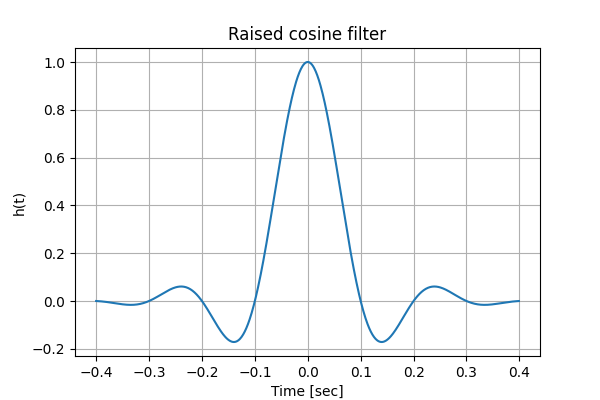

In [6]:
fig2_1 = plt.figure(figsize=(6,4))
ax1 = fig2_1.add_subplot(111)

# ax1.set_title(r'Gaussian shape filter $h(t)=\sqrt{\pi}/\alpha\cdot\exp[-(\pi t_{norm}/\alpha)^2]$, where $t_{norm}=t/T_s$')
ax1.set_title("Raised cosine filter")
ax1.plot(shape_filter.get_abs_time(symb_per_sec), shape_filter.h_impulse_response)
ax1.set_ylabel('h(t)')
ax1.set_xlabel('Time [sec]')
ax1.grid()

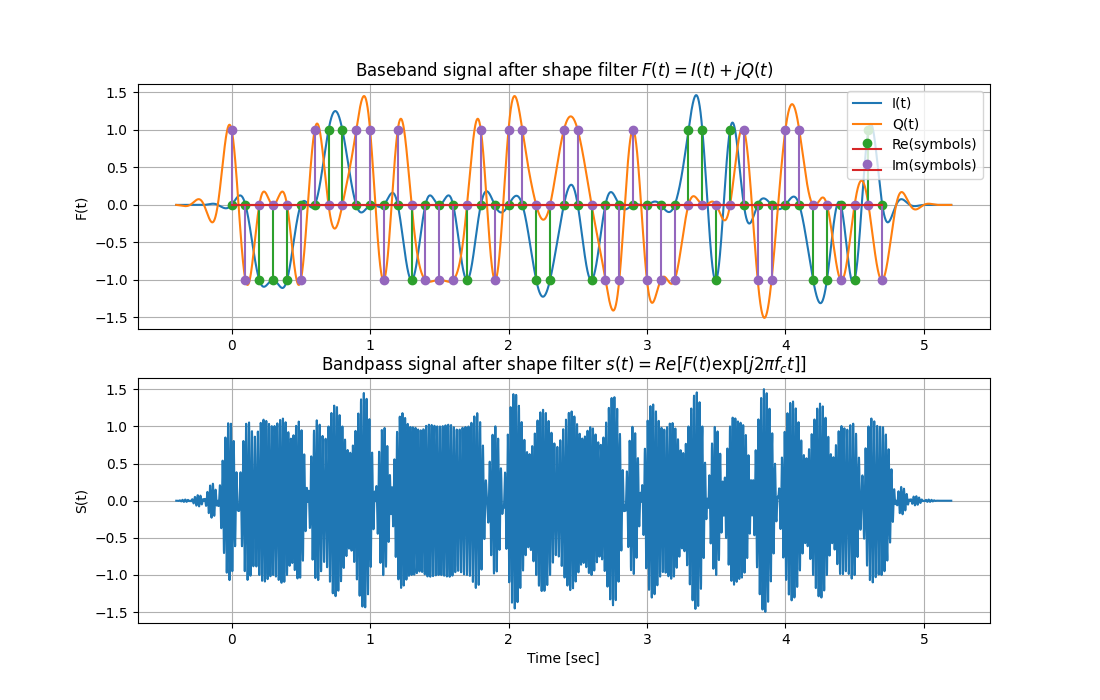

In [7]:
fig2_2 = plt.figure(figsize=(11,7))

ax1 = fig2_2.add_subplot(211)

ax1.set_title(r'Baseband signal after shape filter $F(t)=I(t)+jQ(t)$')
ax1.plot(time_samples, np.real(output_baseband_signal), label='I(t)')
ax1.plot(time_samples, np.imag(output_baseband_signal), label='Q(t)')
ax1.stem(np.arange(0, len(bit_message)//modem_block.get_bits_per_symbol)/symb_per_sec, np.real(symbols), linefmt='C2-', markerfmt='C2o',label='Re(symbols)')
ax1.stem(np.arange(0, len(bit_message)//modem_block.get_bits_per_symbol)/symb_per_sec, np.imag(symbols), linefmt='C4-', markerfmt='C4o',label='Im(symbols)')
ax1.set_ylabel('F(t)')
ax1.legend()
ax1.grid()

ax2 = fig2_2.add_subplot(212)

ax2.set_title(r'Bandpass signal after shape filter $s(t)=Re[F(t)\exp[j2\pi f_ct]]$')
ax2.plot(time_samples, output_bandpass_signal)
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('S(t)')
ax2.grid()

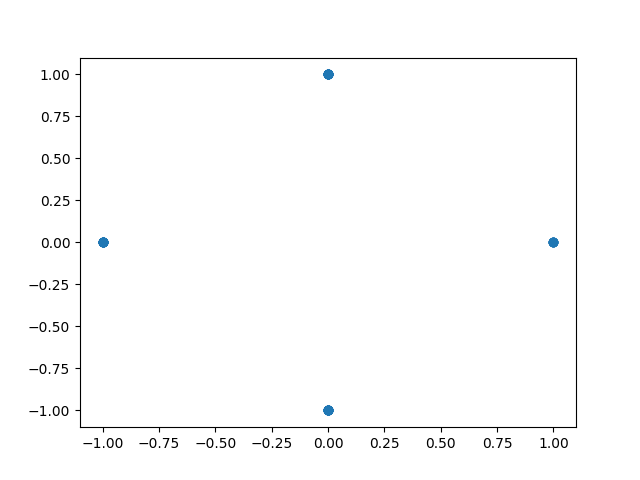

In [8]:
plt.figure()

plt.scatter(np.real(output_baseband_signal[(4*int(fs_hz/symb_per_sec))::int(fs_hz/symb_per_sec)])[:-4], np.imag(output_baseband_signal[(4*int(fs_hz/symb_per_sec))::int(fs_hz/symb_per_sec)])[:-4])
plt.show()

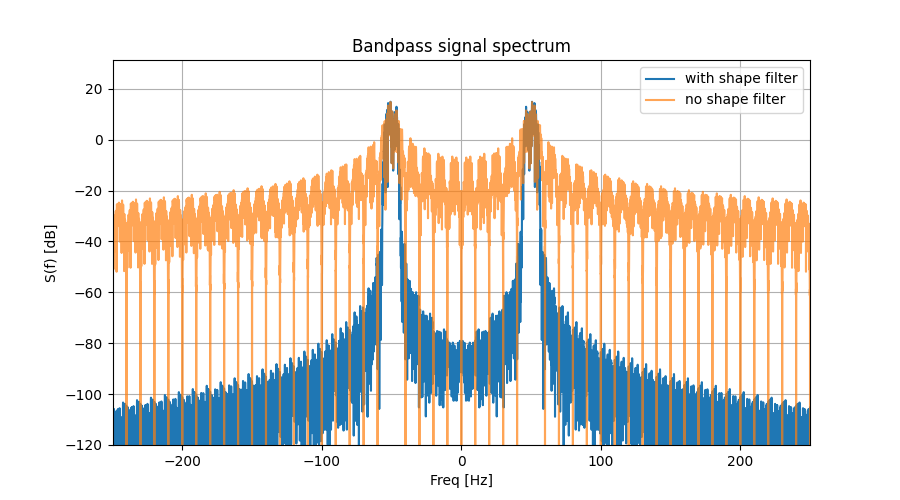

In [16]:
fig2_2 = plt.figure(figsize=(9,5))
ax1 = fig2_2.add_subplot(111)

ax1.set_title(r'Bandpass signal spectrum')
ax1.plot(freqs, 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(output_bandpass_signal, n=n_fft, norm="ortho")))), label="with shape filter")
ax1.plot(freqs, 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal1, n=n_fft, norm="ortho")))), alpha=0.7, label="no shape filter")
ax1.set_xlabel('Freq [Hz]')
ax1.set_ylabel('S(f) [dB]')
ax1.set_xlim(left=-fs_hz/4, right=fs_hz/4)
ax1.set_ylim(bottom=-120)
ax1.legend()
ax1.grid()

### Task 3

In [10]:
data_bpsk = np.load('src/data_bpsk.npy')
data_qpsk = np.load('src/data_qpsk.npy')
data_scramb = np.load('src/scramb.npy')

In [11]:
bpsk_reduced = data_bpsk[24::4]
bpsk_reduced = bpsk_reduced[:100]
qpsk_reduced = data_qpsk[24::4]
qpsk_reduced = qpsk_reduced[:100]

In [12]:
descr_seq = np.exp(-1j*2*np.pi/8*data_scramb)
descr_bpsk = bpsk_reduced*descr_seq
descr_qpsk = qpsk_reduced*descr_seq

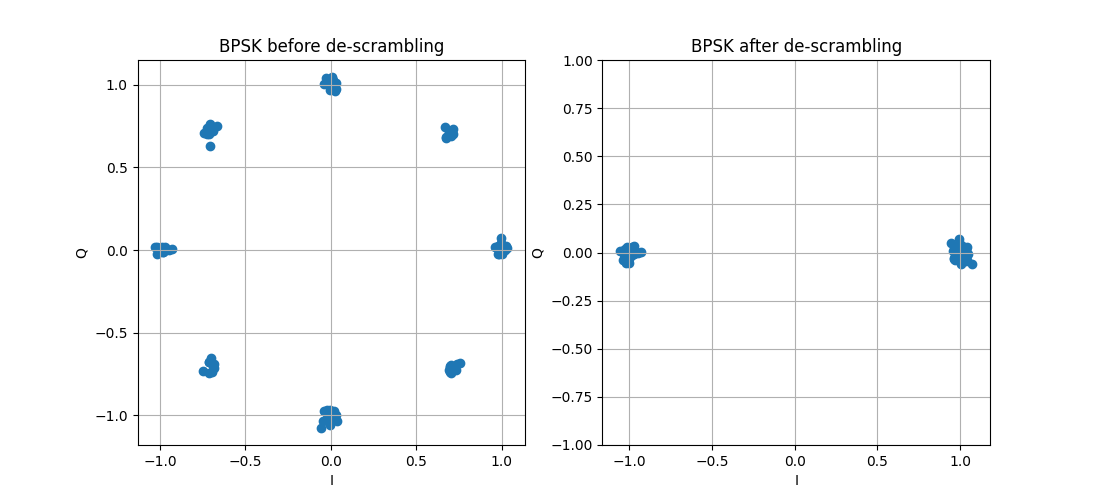

In [13]:
fig3_1 = plt.figure(figsize=(11,5))

ax_1 = fig3_1.add_subplot(121)
ax_1.set_title(r'BPSK before de-scrambling')
ax_1.scatter(np.real(bpsk_reduced), np.imag(bpsk_reduced))
ax_1.set_xlabel('I')
ax_1.set_ylabel('Q')
ax_1.grid()

ax_2 = fig3_1.add_subplot(122)
ax_2.set_title(r'BPSK after de-scrambling')
ax_2.scatter(np.real(descr_bpsk), np.imag(descr_bpsk))
ax_2.set_xlabel('I')
ax_2.set_ylabel('Q')
ax_2.set_ylim(bottom=-1, top=1)
ax_2.grid()

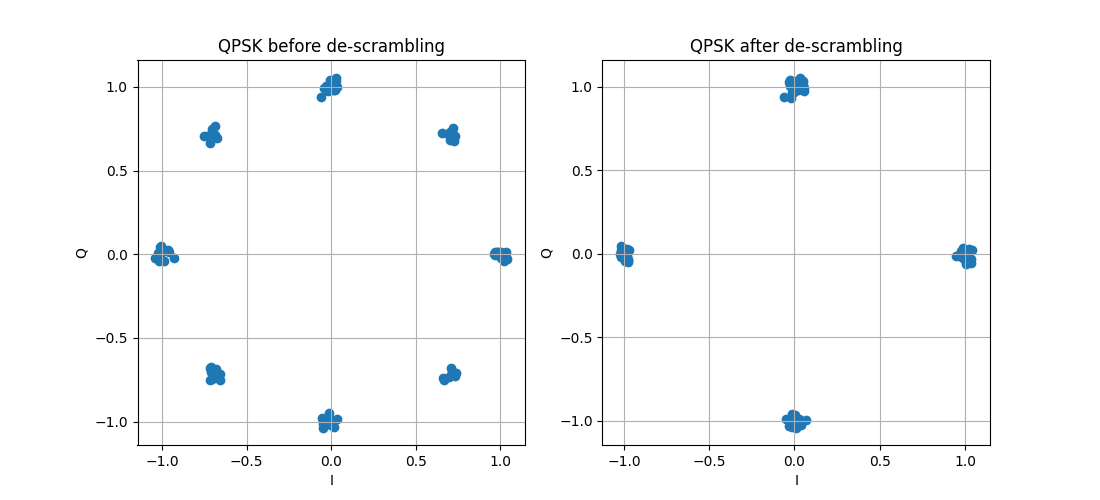

In [14]:
fig3_2 = plt.figure(figsize=(11,5))

ax_1 = fig3_2.add_subplot(121)
ax_1.set_title(r'QPSK before de-scrambling')
ax_1.scatter(np.real(qpsk_reduced), np.imag(qpsk_reduced))
ax_1.set_xlabel('I')
ax_1.set_ylabel('Q')
ax_1.grid()

ax_2 = fig3_2.add_subplot(122)
ax_2.set_title(r'QPSK after de-scrambling')
ax_2.scatter(np.real(descr_qpsk), np.imag(descr_qpsk))
ax_2.set_xlabel('I')
ax_2.set_ylabel('Q')
ax_2.grid()

In [15]:
bpsk_message = modem_block.demap_symbols(descr_bpsk)
qpsk_message = modem_block.demap_symbols(descr_qpsk)
print('BPSK bits:',*bpsk_message)
print('QPSK bits:',*qpsk_message)

BPSK bits: 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1
QPSK bits: 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0
